In [17]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append("..")
from RunningScripts.read_wandb import wandb_results
api = wandb_results("206713612", wandb_username="maayan-aytek1")

BASE_METRIC = "accuracy_per_mean_user_and_bot"

In [3]:
import os
current_dir = os.path.dirname(os.path.abspath('__file__'))
csv_dir_path = os.path.join(os.path.dirname(current_dir), 'RunningScripts')

In [4]:
def result_metric(sweeps, group_name, drop_list=[0], drop_HPT=False, metric=BASE_METRIC, epoch="best", dummy_group=False, model=False):
    df = api.get_sweeps_results(sweeps, metric=metric, dir_path=csv_dir_path) 
    config_cols = [c for c in df.columns if "config_" in c and c!="config_wandb_run_id" and c!="config_online_simulation_size"]
    HPT_cols = [col for col in config_cols if df[col].nunique() > 1]
    if drop_HPT:
        df=df.drop([c for c in HPT_cols if not c in ["config_LLM_SIM_SIZE", "config_seed"]], axis=1)
        HPT_cols = ["config_LLM_SIM_SIZE", "config_seed"]  
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    if model: 
        df['config_rt_model_file_name'] = df['config_rt_model_file_name'].apply(lambda x: x.split('_seed')[0])
    if not dummy_group:
        grouped = df.groupby([c for c in HPT_cols if c != "config_seed"])
    else:
        df['dummy_group'] = 'New LLM'
        
        grouped = df.groupby('dummy_group')
    
    mean_df = grouped[numeric_cols].mean()
    std_df = grouped[numeric_cols].std()
    
    if epoch=="best":
        best_col = mean_df[[c for c in mean_df.columns if (metric in c and metric[-4:] == c.split("_epoch")[0][-4:])]].idxmax(axis=1)
    else:
        best_col = mean_df[[c for c in mean_df.columns if f"{metric}_epoch{epoch}" in c]].idxmax(axis=1)
    
    result = grouped.apply(lambda x: x[best_col.loc[x.name]].values)
    means = grouped.apply(lambda x: x[best_col.loc[x.name]].mean())
    stds = grouped.apply(lambda x: x[best_col.loc[x.name]].std())
    
    df_cols = {'mean': means, 'std': stds, 'values': result.values}
    
    if epoch == "best":
        df_cols['epoch'] = best_col.apply(lambda x: int(x.split("epoch")[1]) if "epoch" in x else "last")
    
    df_cols['CI'] = result.apply(lambda x: bootstrap_ci(x))
    summary_df = pd.DataFrame(df_cols, index=best_col.index)
    
    for d in drop_list:
        if d in summary_df.index:
            summary_df=summary_df.drop(d)

    if len(summary_df.index.names) == 1:
        return summary_df.rename_axis(group_name)
    else:
        return summary_df

def bootstrap_ci(data, n_bootstrap=1000, ci=0.95):
    bootstrapped_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(np.mean(sample))
    lower_bound = np.percentile(bootstrapped_means, (1 - ci) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_means, (1 + ci) / 2 * 100)
    return lower_bound, upper_bound


# For HyperParameterTuning

For every configuration that you test in the sweep, you will receive in the table the average, standard deviation, all the values obtained for the different seed values, and also the confidence interval within which the result is located at a confidence level of 95%.

When epoch="best" is defined, you can check in which epoch the best result is obtained. If epoch=5 is defined, you will receive the result obtained for epoch number 5.

You can test multiple sweeps simultaneously by entering them into the list found in the first element of the function result_metric.

### Baseline

In [5]:
sweep_results = result_metric(["nh9eyaq1"], "LLMs", drop_HPT=False, epoch='best', dummy_group=True)
sweep_results

Total number of sweeps: 1
Download sweep_id='nh9eyaq1' data...


,mean,std,values,epoch,CI
LLMs,,,,,
New LLM,0.83619,0.001682,"[0.8371521808705251, 0.834866139441589, 0.8339...",14,"(0.8347828277726637, 0.8374292824620628)"


### Random

In [6]:
sweep_results = result_metric(["gihrejb0"], "LLMs", drop_HPT=False, epoch='best')
sweep_results

Total number of sweeps: 1
Download sweep_id='gihrejb0' data...


,mean,std,values,epoch,CI
LLMs,,,,,
normal,0.839446,0.002792,"[0.8417926790544936, 0.841346422342924, 0.8374...",22,"(0.8370214997656067, 0.8414745227670034)"
uniform,0.838915,0.001628,"[0.8413149271737511, 0.8377004597636084, 0.839...",16,"(0.8377142146690236, 0.8402655680139134)"


### Models

In [17]:
sweep_results = result_metric(["42wibgw1"], "LLMs", drop_HPT=False, epoch='best', dummy_group=False, model=True)
sweep_results

Total number of sweeps: 1
Download sweep_id='42wibgw1' data...


,,,,mean,std,values,epoch,CI
config_rt_model_file_name,config_rt_model_class_weight,config_rt_model_top_features,config_rt_model_min_samples_leaf,,,,,
min_samples_leaf_100_class_weight_balanced_subsample_top_features_20,balanced_subsample,20,100,0.836768,0.001404,"[0.8351968767317809, 0.8379012449859079, 0.837...",21,"(0.8351968767317809, 0.8379012449859079)"
min_samples_leaf_100_class_weight_balanced_subsample_top_features_all,balanced_subsample,all,100,0.836900,0.000252,"[0.8371155752297419, 0.8366225382946252, 0.836...",9,"(0.8366225382946252, 0.8371155752297419)"
min_samples_leaf_100_class_weight_balanced_top_features_20,balanced,20,100,0.837315,0.001356,"[0.8385974426912752, 0.8374519736681949, 0.835...",18,"(0.8358950308736369, 0.8385974426912752)"
min_samples_leaf_100_class_weight_balanced_top_features_all,balanced,all,100,0.837462,0.002099,"[0.8398647309850867, 0.835986445817165, 0.8365...",18,"(0.835986445817165, 0.8398647309850867)"
min_samples_leaf_20_class_weight_balanced_subsample_top_features_20,balanced_subsample,20,20,0.836669,0.001892,"[0.8379861002281137, 0.834501391657148, 0.8375...",12,"(0.834501391657148, 0.8379861002281137)"
min_samples_leaf_20_class_weight_balanced_subsample_top_features_all,balanced_subsample,all,20,0.837695,0.001677,"[0.8377945331370256, 0.8359706140758668, 0.839...",11,"(0.8359706140758668, 0.8393197174370671)"
min_samples_leaf_20_class_weight_balanced_top_features_20,balanced,20,20,0.836614,0.001761,"[0.8356686748178921, 0.8355273771061232, 0.838...",17,"(0.8355273771061232, 0.8386460324534374)"
min_samples_leaf_20_class_weight_balanced_top_features_all,balanced,all,20,0.836802,0.001410,"[0.8379406353880007, 0.8352242637813103, 0.837...",15,"(0.8352242637813103, 0.8379406353880007)"
min_samples_leaf_50_class_weight_balanced_subsample_top_features_20,balanced_subsample,20,50,0.837531,0.002032,"[0.8383367194971337, 0.8352194818445661, 0.839...",13,"(0.8352194818445661, 0.8390366751829358)"


### Heuristic

In [30]:
sweep_results = result_metric(["rr4bf5bj"], "LLMs", drop_HPT=False, epoch='best', dummy_group=False)
sweep_results.reset_index()

Total number of sweeps: 1
Download sweep_id='rr4bf5bj' data...


,config_rt_user_noise_std,config_rt_neutral_sampling,config_rt_frustration_std_method,mean,std,values,epoch,CI
0,200,1000,+,0.836979,0.001992,"[0.8400159701451503, 0.8374672073500151, 0.834...",20,"(0.835508510753624, 0.8386065825734462)"
1,200,1000,/,0.837570,0.002598,"[0.8393964648476003, 0.8355232446906189, 0.839...",last,"(0.8354718042123036, 0.8394873807381027)"
2,200,800,+,0.837341,0.002995,"[0.8378782271688218, 0.8351722705271559, 0.840...",14,"(0.8350102656603005, 0.8396724216486516)"
3,200,800,/,0.837163,0.002275,"[0.8388582202235954, 0.8338600988903725, 0.836...",19,"(0.8353541311863246, 0.8388281644230622)"
4,200,normal,+,0.837345,0.001237,"[0.8365394680610218, 0.8384429625645824, 0.836...",12,"(0.8364254228451934, 0.8383448839529024)"
5,200,normal,/,0.837635,0.002379,"[0.839637143670511, 0.8401320919190824, 0.8344...",11,"(0.8357560426088992, 0.8394628844213561)"
6,300,1000,+,0.838036,0.002364,"[0.8414243308476722, 0.839321243925161, 0.8364...",14,"(0.8363162179299343, 0.839851659987934)"
7,300,1000,/,0.836368,0.000789,"[0.8366641666218375, 0.8354961955228851, 0.837...",14,"(0.8357412774935529, 0.8369838304369315)"
8,300,800,+,0.837205,0.001097,"[0.8390263045485709, 0.8369912642463646, 0.837...",18,"(0.8365180792493341, 0.8381647341407689)"
9,300,800,/,0.836295,0.001916,"[0.8346060943480512, 0.8390550693024155, 0.834...",8,"(0.8348687521753421, 0.8378505506671526)"


In [4]:
sweep_results = result_metric(["1f6wyb4r"], "LLMs", drop_HPT=False, epoch='best')
sweep_results.reset_index()

Total number of sweeps: 1
Download sweep_id='1f6wyb4r' data...


100%|██████████| 120/120 [00:03<00:00, 35.23it/s]


,config_rt_w_word_count,config_rt_user_noise_std,config_rt_neutral_sampling,config_rt_frustration_std_method,mean,std,values,epoch,CI
0,100,300,800,+,0.836098,0.003945,"[0.8312215119669927, 0.8387861448970098, 0.839...",10,"(0.8329816757196836, 0.8389651217566325)"
1,100,300,800,/,0.836380,0.001314,"[0.8372142463384018, 0.8356490051098989, 0.837...",19,"(0.8354430622667696, 0.8373174358740698)"
2,100,300,normal,+,0.837853,0.002778,"[0.8412844941562723, 0.8363074071569248, 0.839...",9,"(0.8354709377486553, 0.8398306125506327)"
3,100,300,normal,/,0.836647,0.001719,"[0.8366933024055729, 0.8344399394704348, 0.838...",11,"(0.8353416328545687, 0.8379522165715176)"
4,100,500,800,+,0.837195,0.001534,"[0.8367860290486224, 0.8371434476197307, 0.836...",9,"(0.8361072775734435, 0.8385493728903652)"
5,100,500,800,/,0.837437,0.003066,"[0.8325561099346298, 0.8381951834093676, 0.840...",11,"(0.834811739324525, 0.8396005129647532)"
6,100,500,normal,+,0.838568,0.001077,"[0.8390195174183207, 0.8379832168384272, 0.838...",11,"(0.8377919003473663, 0.839489545377449)"
7,100,500,normal,/,0.835588,0.002369,"[0.8356821543653872, 0.836603676611369, 0.8389...",23,"(0.8336582834949802, 0.8373451393952781)"
8,125,300,800,+,0.836645,0.001882,"[0.8373728202163232, 0.83714393461135, 0.83890...",13,"(0.8351695355162859, 0.8379624993666083)"
9,125,300,800,/,0.837751,0.001996,"[0.8401258893876667, 0.8390106170314376, 0.837...",15,"(0.8361468610101264, 0.8392472356218615)"


### RT Representation

In [7]:
sweep_results = result_metric(["0381z4nx"], "LLMs", drop_HPT=False, epoch='best')
sweep_results.reset_index().sort_values(by="mean", ascending=False)

Total number of sweeps: 1
Download sweep_id='0381z4nx' data...


,config_input_dim,config_rt_baseline_std,config_rt_w_word_count,config_rt_bins_option_num,config_rt_bins_columns_rep,mean,std,values,epoch,CI
23,60,1000,150,0,one-hot,0.838727,0.002408,"[0.8401788520016553, 0.8359475008356176, 0.840...",9,"(0.8359475008356178, 0.8401788520016553)"
21,60,500,150,0,one-hot,0.837627,0.003131,"[0.8427695550000989, 0.8351287317714683, 0.838...",23,"(0.8355452246649134, 0.8404579652677164)"
24,61,0,125,0,both,0.837449,0.001944,"[0.8369105586724874, 0.837977145485305, 0.8366...",16,"(0.8361131016868433, 0.839034390576723)"
18,60,0,125,0,one-hot,0.837213,0.001145,"[0.8354284579898273, 0.8374474727140917, 0.836...",19,"(0.8362360638795332, 0.8380112441676927)"
29,61,500,150,0,both,0.837199,NaN,[0.8371991778935945],18,"(0.8371991778935945, 0.8371991778935945)"
20,60,500,125,0,one-hot,0.836566,0.001246,"[0.8372656524214185, 0.8371542080645357, 0.834...",14,"(0.8354525544150405, 0.8374226352232508)"
22,60,1000,125,0,one-hot,0.836386,0.001402,"[0.8356741829489508, 0.8378905578479436, 0.834...",9,"(0.8353182841585184, 0.8374132883326324)"
19,60,0,150,0,one-hot,0.836226,0.001397,"[0.8373215859800484, 0.8368107487126704, 0.837...",16,"(0.8349993189208104, 0.8371528803211047)"
26,61,0,150,0,both,0.835995,0.001153,"[0.8355904069039789, 0.8347365093242435, 0.835...",12,"(0.8352001161312355, 0.8369576913251061)"
39,66,0,150,2,one-hot,0.834203,0.002501,"[0.8360296390623763, 0.8361267490553906, 0.835...",21,"(0.8320143535967252, 0.8358816433211171)"


In [5]:
sweep_results = result_metric(["elct280c"], "LLMs", drop_HPT=False, epoch='best')
sweep_results.reset_index().sort_values(by="mean", ascending=False)

Total number of sweeps: 1
Download sweep_id='elct280c' data...


100%|██████████| 90/90 [00:02<00:00, 39.56it/s]


,config_input_dim,config_rt_bins_option_num,config_rt_bins_columns_rep,config_rt_sampling_distribution,mean,std,values,epoch,CI
9,61,0,both,uniform,0.838557,0.001784,"[0.8368175755631474, 0.8398682831300783, 0.839...",14,"(0.8371920075894519, 0.8399073724137432)"
6,60,0,one-hot,normal,0.838114,0.002923,"[0.836975102149344, 0.838302228748287, 0.83957...",15,"(0.8356900991543057, 0.8403724003439818)"
8,61,0,both,normal,0.836233,0.001865,"[0.833503279110266, 0.8350806726318529, 0.8377...",12,"(0.8346726944580187, 0.8375341263385605)"
7,60,0,one-hot,uniform,0.835636,0.002291,"[0.8369918168943377, 0.8352967931654662, 0.835...",22,"(0.8338474402271597, 0.8374837091421405)"
14,66,2,one-hot,normal,0.834726,0.003391,"[0.8317206224116411, 0.8330481336548199, 0.834...",15,"(0.8326134549922173, 0.83759067515361)"
16,67,2,both,normal,0.834366,0.004224,"[0.830253546544186, 0.8384409700502101, 0.8309...",14,"(0.831216972428772, 0.8376616579063578)"
15,66,2,one-hot,uniform,0.833809,0.003548,"[0.8280899592640225, 0.8363338294483107, 0.837...",8,"(0.8308951642909188, 0.8361744976526879)"
17,67,2,both,uniform,0.833623,0.000956,"[0.8342407711345775, 0.833062873778419, 0.8322...",9,"(0.8328166589473719, 0.8343329912634097)"
11,61,1,one-hot,uniform,0.833488,0.001617,"[0.8326290440627685, 0.8337489093870296, 0.836...",15,"(0.8324198025479289, 0.834949466559366)"
13,62,1,both,uniform,0.833356,0.002435,"[0.8370943381833326, 0.8320616659959371, 0.832...",16,"(0.8316529759152156, 0.8352622036836619)"


## Visualizations

In [7]:
baseline_df = result_metric(["nh9eyaq1"], "LLMs", drop_HPT=False, epoch='best', dummy_group=True).reset_index()
random_df = result_metric(["gihrejb0"], "LLMs", drop_HPT=False, epoch='best').reset_index()
random_df = random_df.rename(columns={'LLMs': 'Sampling Distribution'})
models_df = result_metric(["42wibgw1"], "LLMs", drop_HPT=False, epoch='best', dummy_group=False, model=True).reset_index()
heuristic1_df = result_metric(["rr4bf5bj"], "LLMs", drop_HPT=False, epoch='best', dummy_group=False).reset_index()
heuristic1_df['rt_baseline_std'] = 0
heuristic1_df['config_rt_w_word_count'] = 150
heuristic2_df = result_metric(["1f6wyb4r"], "LLMs", drop_HPT=False, epoch='best').reset_index()
heuristic2_df['rt_baseline_std'] = 700
mean_baseline = baseline_df['mean'].values[0]
random_rep_df = result_metric(["elct280c"], "LLMs", drop_HPT=False, epoch='best').reset_index()
random_rep_df = random_rep_df.rename(columns={'config_rt_sampling_distribution': 'Sampling Distribution'})
heuristic_rep_df = result_metric(["0381z4nx"], "LLMs", drop_HPT=False, epoch='best', dummy_group=False).reset_index()

Total number of sweeps: 1
Download sweep_id='nh9eyaq1' data...


Total number of sweeps: 1
Download sweep_id='gihrejb0' data...
Total number of sweeps: 1
Download sweep_id='42wibgw1' data...
Total number of sweeps: 1
Download sweep_id='rr4bf5bj' data...
Total number of sweeps: 1
Download sweep_id='1f6wyb4r' data...
Total number of sweeps: 1
Download sweep_id='elct280c' data...
Total number of sweeps: 1
Download sweep_id='0381z4nx' data...


/tmp/ipykernel_861909/269275406.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=random_baseline_df, x='Sampling Distribution', y='mean', palette='pastel')


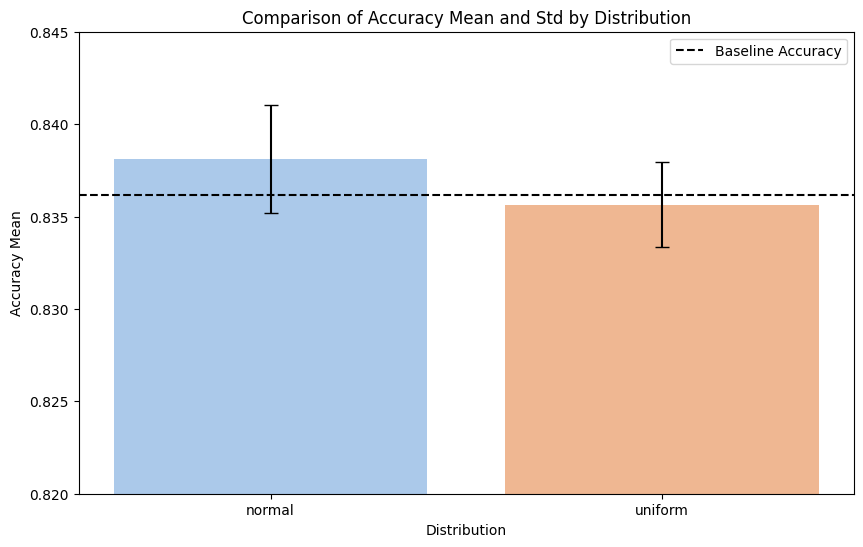

In [19]:
# Create the barplot
random_baseline_df = random_rep_df[(random_rep_df['config_rt_bins_option_num'] == 0) & (random_rep_df['config_rt_bins_columns_rep'] == 'one-hot')].reset_index(drop=True)
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=random_baseline_df, x='Sampling Distribution', y='mean', palette='pastel')

for i in range(len(random_baseline_df)):
    barplot.errorbar(i, random_baseline_df["mean"][i], yerr=random_baseline_df["std"][i], fmt='none', c='black', capsize=5)

plt.axhline(mean_baseline, linestyle='--', color='black', label='Baseline Accuracy')
# Add labels and title
plt.xlabel('Distribution')
plt.ylabel('Accuracy Mean')
plt.title('Comparison of Accuracy Mean and Std by Distribution')
plt.ylim(0.82, 0.845)
plt.legend()
plt.show()


/anaconda/envs/final_project_env/lib/python3.8/site-packages/seaborn/axisgrid.py:186: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


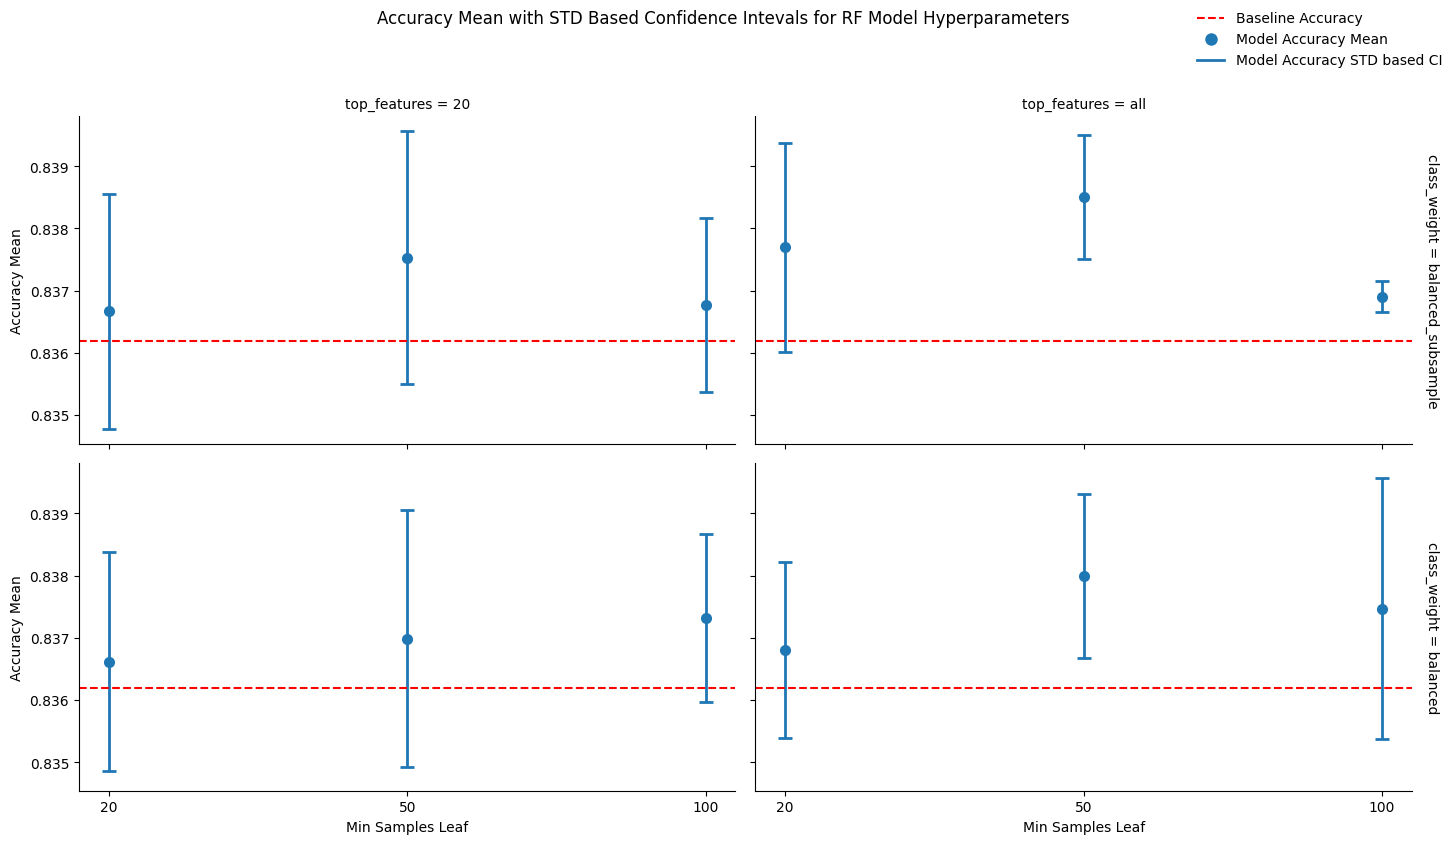

In [9]:
models_df = models_df.sort_values(by='config_rt_model_min_samples_leaf')
models_df['config_rt_model_min_samples_leaf'] = models_df['config_rt_model_min_samples_leaf'].astype('str')
models_df = models_df.rename(columns={"config_rt_model_class_weight": "class_weight", "config_rt_model_top_features": "top_features"})
g = sns.FacetGrid(models_df, col="top_features", row="class_weight", margin_titles=True, height=4, aspect=1.5)

def plot_with_baseline(data, **kwargs):
    plt.errorbar(data["config_rt_model_min_samples_leaf"], data["mean"], yerr=data["std"], fmt="o", capsize=5, elinewidth=2, markeredgewidth=2)
    plt.axhline(mean_baseline, linestyle='--', color='red', label='Baseline Accuracy')

g.map_dataframe(plot_with_baseline)
handles = [
    plt.Line2D([0], [0], color='red', linestyle='--', label='Baseline Accuracy'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:blue', markersize=10, label='Model Accuracy Mean'),
    plt.Line2D([0], [0], color='tab:blue', linestyle='-', linewidth=2, label='Model Accuracy STD based CI')
]
g.add_legend(handles=handles, loc='upper right')
g.fig.suptitle('Accuracy Mean with STD Based Confidence Intevals for RF Model Hyperparameters', y=1.05)
g.set_axis_labels("Min Samples Leaf", "Accuracy Mean")
plt.tight_layout()
plt.show()


In [10]:
heurstic_df = pd.concat([heuristic1_df, heuristic2_df]).reset_index(drop=True)

In [76]:
heurstic_df.sort_values("mean", ascending=False).head(3)

,config_rt_user_noise_std,config_rt_neutral_sampling,config_rt_frustration_std_method,mean,std,values,epoch,CI,rt_baseline_std,config_rt_w_word_count
30,500,800,+,0.838739,0.001797,"[0.8391955103973514, 0.8410532658791899, 0.837...",12,"(0.8374500966342294, 0.8400618834036233)",700,125
14,500,800,+,0.838632,0.001199,"[0.8401141721684653, 0.8393247337820757, 0.838...",19,"(0.8377193496117533, 0.8395451581487936)",0,150
24,500,normal,+,0.838568,0.001077,"[0.8390195174183207, 0.8379832168384272, 0.838...",11,"(0.8377919003473663, 0.8394710428017254)",700,100


In [22]:
heuristic_rep_df.sort_values("mean", ascending=False).head(3)

,config_input_dim,config_rt_baseline_std,config_rt_w_word_count,config_rt_bins_option_num,config_rt_bins_columns_rep,mean,std,values,epoch,CI
23,60,1000,150,0,one-hot,0.838727,0.002408,"[0.8401788520016553, 0.8359475008356176, 0.840...",9,"(0.8359475008356178, 0.8401788520016553)"
21,60,500,150,0,one-hot,0.837627,0.003131,"[0.8427695550000989, 0.8351287317714683, 0.838...",23,"(0.835640900980484, 0.840132250793418)"
24,61,0,125,0,both,0.837449,0.001944,"[0.8369105586724874, 0.837977145485305, 0.8366...",16,"(0.8361131016868433, 0.838966398696335)"


In [19]:
best_random_df = random_rep_df.sort_values(by="mean", ascending=False).iloc[[0]]
best_random_df['method'] = 'Random EDA'
best_random_df = best_random_df[['method', 'mean', 'std']]
best_heuristic_df = heuristic_rep_df.sort_values(by="mean", ascending=False).iloc[[0]]
best_heuristic_df['method'] = 'Heuristic'
best_heuristic_df = best_heuristic_df[['method', 'mean', 'std']]
best_model_df = models_df.sort_values(by="mean", ascending=False).iloc[[0]]
best_model_df['method'] = 'RF Model'
best_model_df = best_model_df[['method', 'mean', 'std']]

best_res_df = pd.concat([best_random_df, best_model_df, best_heuristic_df]).reset_index(drop=True)
best_res_df


,method,mean,std
0,Random EDA,0.838557,0.001784
1,RF Model,0.838501,0.000999
2,Heuristic,0.838727,0.002408


/tmp/ipykernel_1581415/354649727.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=best_res_df, x='method', y='mean', palette='pastel')


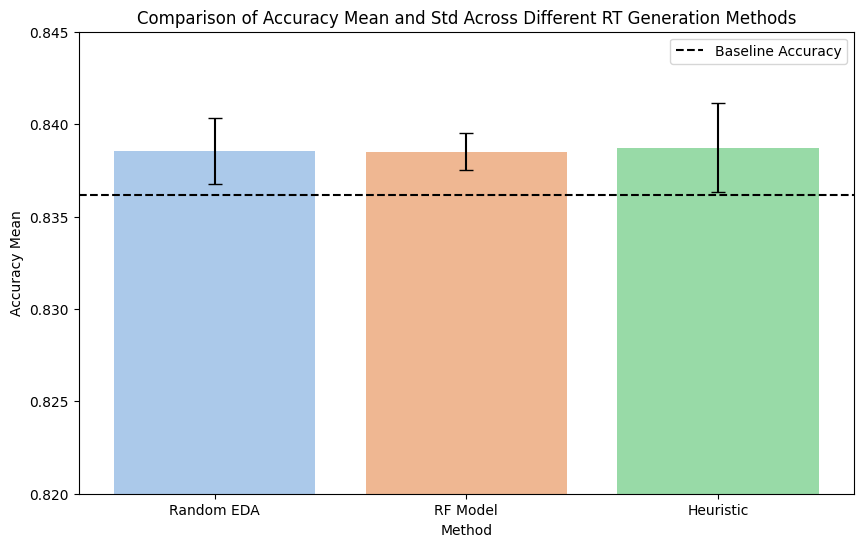

In [20]:
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=best_res_df, x='method', y='mean', palette='pastel')

for i in range(len(best_res_df)):
    barplot.errorbar(i, best_res_df["mean"][i], yerr=best_res_df["std"][i], fmt='none', c='black', capsize=5)

plt.axhline(mean_baseline, linestyle='--', color='black', label='Baseline Accuracy')
# Add labels and title
plt.xlabel('Method')
plt.ylabel('Accuracy Mean')
plt.title('Comparison of Accuracy Mean and Std Across Different RT Generation Methods')
plt.ylim(0.82, 0.845)
plt.legend()
plt.show()